# 동행복권 회차별 로또 정보 요청 API

In [2]:
import requests
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class LottoCash:
    def __init__(self, host, port, db, user, passwd):
        self.host=host
        self.port=port
        self.db=db
        self.user=user
        self.passwd=passwd
        self.lotto_url = "https://www.dhlottery.co.kr/common.do?method=getLottoNumber&drwNo="
        self.drwNo = 0     ## 회차
        
    def db_conn(self):
        try:
            conn = pymysql.connect(host=self.host, port=self.port, db=self.db, user=self.user, passwd=self.passwd)
            return conn
        except Exception as e:
            print(e)
            
    def get_drwNo(self, conn):
        try:
#             mySql connect후 cursor를 활용하는 방식에서 pandas의 read_sql(DataFrame)활용으로 변경
#             cursor = conn.cursor()
#             cursor.execute("""SELECT drwNo FROM lotto LIMIT1 ORDER BY drwNo desc """)
#             df_result = pd.DataFrame(cursor.fetchall())
#             print("result = "+str(df_result[0][0]))
            sql = """select drwNo From lotto ORDER BY drwNo desc LIMIT 1"""
            df_result = pd.read_sql(sql, conn)
            df_result['drwNo'][0]

            if df_result.empty:
                self.drwNo = 1
            else:
                self.drwNo = df_result['drwNo'][0]+1
            print("수집할 회차 : "+str(self.drwNo))
        except Exception as e:
            conn.close()
            print(e)
            
    
    def get_lottoInfo(self, conn=None):
        if conn is not None:    # 회차별 로또 정보 가져오기 From DB(MySql)
            try:
                sql = """SELECT drwNo
                                , drwNoDate
                                , drwtNo1, drwtNo2, drwtNo3, drwtNo4, drwtNo5, drwtNo6, bnusNo
                                , firstAccumamnt
                                , firstPrzwnerCo
                                , firstWinamnt
                                , totSellamnt
                                , returnValue
                            FROM lotto"""
                result = pd.read_sql(sql, conn)
                return result
            except Exception as e:
                print(e)
        else:    # 회차별 로또 정보 가져오기 From API
            try:
                round_url = self.lotto_url+str(self.drwNo)    # 동행복권 로또API에 원하는 회차를 입력
                print(str(self.drwNo)+"회차 = "+round_url)
                result = requests.get(round_url)
                return result.json()
            except Exception as e:
                print(e)

    def set_lottoInfo(self, conn, round_lottoInfo):
        try:
            cursor = conn.cursor()
            sql = """INSERT INTO lotto (drwNo
                                        , drwNoDate
                                        , drwtNo1, drwtNo2, drwtNo3, drwtNo4, drwtNo5, drwtNo6, bnusNo
                                        , firstAccumamnt
                                        , firstPrzwnerCo
                                        , firstWinamnt
                                        , totSellamnt
                                        , returnValue) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
            datas = (round_lottoInfo.get('drwNo')
                    , round_lottoInfo.get('drwNoDate')
                    , round_lottoInfo.get('drwtNo1')
                    , round_lottoInfo.get('drwtNo2')
                    , round_lottoInfo.get('drwtNo3')
                    , round_lottoInfo.get('drwtNo4')
                    , round_lottoInfo.get('drwtNo5')
                    , round_lottoInfo.get('drwtNo6')
                    , round_lottoInfo.get('bnusNo')
                    , round_lottoInfo.get('firstAccumamnt')
                    , round_lottoInfo.get('firstPrzwnerCo')
                    , round_lottoInfo.get('firstWinamnt')
                    , round_lottoInfo.get('totSellamnt')
                    , round_lottoInfo.get('returnValue'))
            print(datas)
            cursor.execute(sql, datas)
            conn.commit()
        except Exception as e:
            conn.close()
            print(e)
        finally:
            cursor.close()

In [4]:
lotto = LottoCash('localhost', 3306, 'lotto', 'administrator', '12qwaszx!@')

## 수집할 회차 정보 조회

In [5]:
conn = lotto.db_conn()
lotto.get_drwNo(conn)

수집할 회차 : 999


## 데이터 수집 및 DB 적재

In [6]:
while True:
    round_lottoInfo = lotto.get_lottoInfo()
    if "fail"!=round_lottoInfo.get('returnValue'):
        lotto.set_lottoInfo(conn, round_lottoInfo)    
        lotto.drwNo = lotto.drwNo+1
    else:
        break
    

999회차 = https://www.dhlottery.co.kr/common.do?method=getLottoNumber&drwNo=999


In [7]:
# conn.close()

## 최다/최소 빈도 번호 구하기

In [8]:
lottoData = lotto.get_lottoInfo(conn)
lottoData

,drwNo,drwNoDate,drwtNo1,drwtNo2,drwtNo3,drwtNo4,drwtNo5,drwtNo6,bnusNo,firstAccumamnt,firstPrzwnerCo,firstWinamnt,totSellamnt,returnValue
0,1,2002-12-07,10,23,29,33,37,40,16,863604600,0,0,3681782000,success
1,2,2002-12-14,9,13,21,25,32,42,2,0,1,2002006800,4904274000,success
2,3,2002-12-21,11,16,19,21,27,31,30,0,1,2000000000,4729342000,success
3,4,2002-12-28,14,27,30,31,40,42,2,1267147200,0,0,5271464000,success
4,5,2003-01-04,16,24,29,40,41,42,3,3041094900,0,0,6277102000,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,994,2021-12-18,1,3,8,24,27,35,28,22338984756,12,1861582063,95530936000,success
994,995,2021-12-25,1,4,13,29,38,39,7,24130903125,7,3447271875,100878455000,success
995,996,2022-01-01,6,11,15,24,32,39,28,26841343878,18,1491185771,112624327000,success
996,997,2022-01-08,4,7,14,16,24,44,20,23821241640,19,1253749560,102431961000,success


In [9]:
numbers = lottoData[['drwtNo1', 'drwtNo2', 'drwtNo3', 'drwtNo4', 'drwtNo5', 'drwtNo6', 'bnusNo']]
numbers.T # 편하게 보기 위함..(취향)

,0,1,2,3,4,5,6,7,8,9,...,988,989,990,991,992,993,994,995,996,997
drwtNo1,10,9,11,14,16,14,2,8,2,9,...,17,2,13,12,6,1,1,6,4,13
drwtNo2,23,13,16,27,24,15,9,19,4,25,...,18,4,18,20,14,3,4,11,7,17
drwtNo3,29,21,19,30,29,26,16,25,16,30,...,21,25,25,26,16,8,13,15,14,18
drwtNo4,33,25,21,31,40,27,25,34,17,33,...,27,26,31,33,18,24,29,24,16,20
drwtNo5,37,32,27,40,41,40,26,37,36,41,...,29,36,33,44,24,27,38,32,24,42
drwtNo6,40,42,31,42,42,42,40,39,39,44,...,33,37,44,45,42,35,39,39,44,45
bnusNo,16,2,30,2,3,34,42,9,14,6,...,26,28,38,24,44,28,7,28,20,41


In [10]:
# 결측치 개수 확인
numbers.isnull().sum()

drwtNo1    0
drwtNo2    0
drwtNo3    0
drwtNo4    0
drwtNo5    0
drwtNo6    0
bnusNo     0
dtype: int64

In [11]:
listNo=numbers.values.tolist()
listNo_sum = sum(listNo, [])
df_listNo = pd.DataFrame(listNo_sum)
df_listNo.T

,0,1,2,3,4,5,6,7,8,9,...,6976,6977,6978,6979,6980,6981,6982,6983,6984,6985
0,10,23,29,33,37,40,16,9,13,21,...,24,44,20,13,17,18,20,42,45,41


In [12]:
top6 = df_listNo.value_counts().head(6)
bottom6 = df_listNo.value_counts().tail(6)
print("빈도 수 상위 6개 = \n" + str(top6))
print("빈도 수 하위 6개 = \n" + str(bottom6))
print("빈도 수 상위 6개 = " + str([no[0] for no in top6.index]))
print("빈도 수 하위 6개 = " + str([no[0] for no in bottom6.index]))

빈도 수 상위 6개 = 
43    179
27    171
34    170
13    170
1     170
17    168
dtype: int64
빈도 수 하위 6개 = 
32    139
23    138
41    138
29    135
9     128
22    127
dtype: int64
빈도 수 상위 6개 = [43, 27, 34, 13, 1, 17]
빈도 수 하위 6개 = [32, 23, 41, 29, 9, 22]


In [13]:
# print([no[0] for no in df_listNo.value_counts().index])
# print(df_listNo.value_counts().values.tolist())
# max(df_listNo.value_counts().values.tolist())
# min(df_listNo.value_counts().values.tolist())

## 번호별 통계

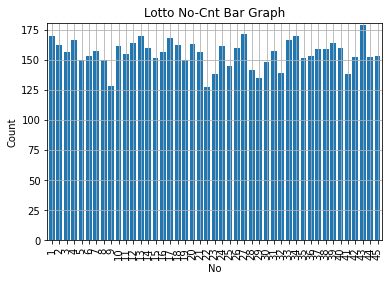

In [14]:
plt.title("Lotto No-Cnt Bar Graph")
plt.xlabel("No")
plt.ylabel("Count")
plt.bar([no[0] for no in df_listNo.value_counts().index], df_listNo.value_counts().values.tolist(), width=0.8)
plt.rcParams['figure.figsize'] = [15,10]
plt.xticks(range(1,46), rotation=90, size=10)
plt.margins(x=0.005, y=0.01)
plt.grid()
plt.show()

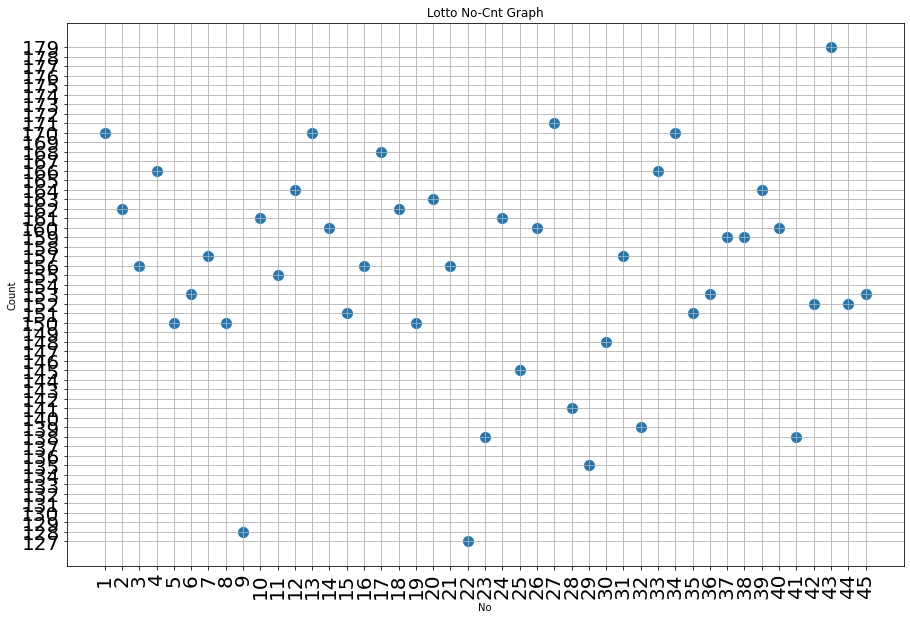

In [15]:
plt.title("Lotto No-Cnt Graph")
plt.xlabel("No")
plt.ylabel("Count")
plt.scatter([no[0] for no in df_listNo.value_counts().index], df_listNo.value_counts().values.tolist(), s=100)
plt.rcParams['figure.figsize'] = [15,15]
plt.xticks(range(1,46), rotation=90, size=20)
plt.yticks(range(min(df_listNo.value_counts().values.tolist()), max(df_listNo.value_counts().values.tolist())+1), size=20)
plt.grid()
plt.show()

## 색상 통계(번호별)

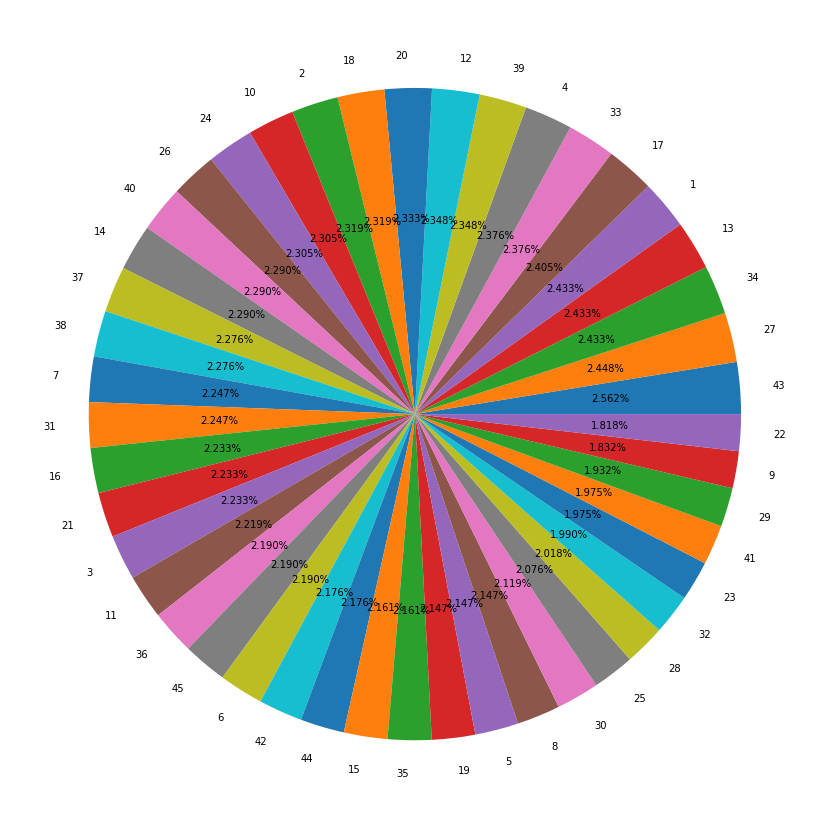

In [16]:
cnt = df_listNo.value_counts().values.tolist()
no = [no[0] for no in df_listNo.value_counts().index]
plt.pie(cnt, labels=no, autopct='%.3f%%')
plt.show()

### 번호대별 통계
#### v1 -> (1 ~ 9), (10 ~ 19), (20 ~ 29), (30 ~ 39), (40 ~ 45)
#### v2 -> (1 ~ 10), (11 ~ 20), (21 ~ 30), (31 ~ 40), (41 ~ 45)
#### v3 -> (1 ~ 5), (6 ~ 10), (11 ~ 15), (16 ~ 20), (21 ~ 25), (26 ~ 30), (31 ~ 35), (36 ~ 40), (41 ~ 45)

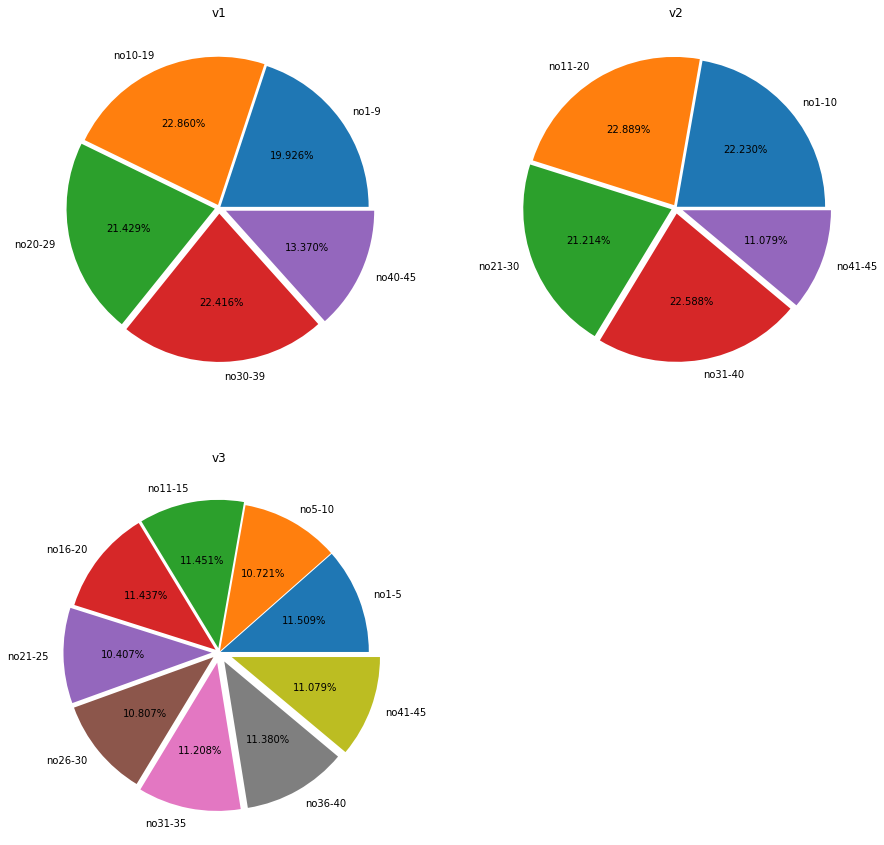

In [17]:
# numbers.T
# df_listNo.T
noCnt=df_listNo.value_counts()
noCnt.sort_index()
noA=noB=noC=noD=noE = 0
no1=no11=no21=no31=no41 = 0
no5=no10=no15=no20=no25=no30=no35=no40=no45 = 0

# v1
for index in noCnt.index:
    if 0<index[0]<10:
        noA=noA+noCnt[index]
    elif 10<=index[0]<20:
        noB=noB+noCnt[index]
    elif 20<=index[0]<30:
        noC=noC+noCnt[index]
    elif 30<=index[0]<40:
        noD=noD+noCnt[index]
    elif 40<=index[0]<46:
        noE=noE+noCnt[index]

# v2, v3
for index in noCnt.index:
    if 0<index[0]<=10:
        no1=no1+noCnt[index]
        if index[0] < 6:
            no5=no5+noCnt[index]
        else:
            no10=no10+noCnt[index]
    
    elif 11<=index[0]<21:
        no11=no11+noCnt[index]
        if index[0] < 16:
            no15=no15+noCnt[index]
        else:
            no20=no20+noCnt[index]
    
    elif 21<=index[0]<31:
        no21=no21+noCnt[index]
        if index[0] < 26:
            no25=no25+noCnt[index]
        else:
            no30=no30+noCnt[index]
    
    elif 31<=index[0]<41:
        no31=no31+noCnt[index]
        if index[0] < 36:
            no35=no35+noCnt[index]
        else:
            no40=no40+noCnt[index]
    
    elif 41<=index[0]:
        no41=no41+noCnt[index]
        no45=no41

noRange1 = [noA, noB, noC, noD, noE]
noRange2 = [no1, no11, no21, no31, no41]
noRange3 = [no5, no10, no15, no20, no25, no30, no35, no40, no45]

labels1 = ["no1-9", "no10-19", "no20-29", "no30-39", "no40-45"]
labels2 = ["no1-10", "no11-20", "no21-30", "no31-40", "no41-45"]
labels3 = ["no1-5", "no5-10", "no11-15", "no16-20", "no21-25", "no26-30", "no31-35", "no36-40", "no41-45"]

plt.subplot(221)
plt.title("v1")
type1 = plt.pie(noRange1, labels=labels1, autopct='%.3f%%', explode=[0.01,0.02,0.03,0.04,0.05])

plt.subplot(222)
plt.title("v2")
type2 = plt.pie(noRange2, labels=labels2, autopct='%.3f%%', explode=[0.01,0.02,0.03,0.04,0.05])

plt.subplot(223)
plt.title("v3")
type3 = plt.pie(noRange3, labels=labels3, autopct='%.3f%%', explode=[0.01, 0.01, 0.03, 0.03, 0.05, 0.05, 0.07, 0.07, 0.09])

# plt.tight_layout
plt.show()

## 추가 테스트(통계를 보고 싶은 데이터 선정해보기)
### ex) 기간별 통계, 금액별 통계

In [91]:
#firstAccumamnt : 1등 총액
#firstPrzwnerCo : 1등 당첨자 수
#firstWinamnt : 1등 당첨액
#totSellamnt : 판매 금액
tenP=int((lotto.drwNo-1)*0.1) # 10퍼센트
faData = lottoData.sort_values(by=['firstAccumamnt'], ascending=False, axis=0).head(tenP)
fpcData = lottoData.sort_values(by=['firstPrzwnerCo'], ascending=True, axis=0).head(tenP)
fwData = lottoData.sort_values(by=['firstWinamnt'], ascending=False, axis=0).head(tenP)
tsData = lottoData.sort_values(by=['totSellamnt'], ascending=False, axis=0).head(tenP)

## 1등 총액 상위 10%에서 가장 많이 나온 수 6개

In [181]:
## 주의 할 점 : 회차로 접근 한것이 아닌 Row Number로 접근한 점
faData
faList=numbers.iloc[faData.index.tolist()].values.tolist()
faList_sum = sum(faList, [])
df_faList=pd.DataFrame(faList_sum)
df_faList.value_counts().head(6)

4     21
2     20
44    20
35    19
24    19
26    19
dtype: int64

In [95]:
fwData[['drwNo', 'drwNoDate', 'drwtNo1', 'drwtNo2', 'drwtNo3', 'drwtNo4', 'drwtNo5', 'drwtNo6', 'bnusNo', 'firstWinamnt']]


,drwNo,drwNoDate,drwtNo1,drwtNo2,drwtNo3,drwtNo4,drwtNo5,drwtNo6,bnusNo,firstWinamnt
18,19,2003-04-12,6,30,38,39,40,43,26,40722959400
24,25,2003-05-24,2,4,21,26,43,44,16,24227745300
19,20,2003-04-19,10,14,18,20,23,30,41,19352212800
42,43,2003-09-27,6,31,35,38,39,44,1,17749630800
14,15,2003-03-15,3,4,16,30,31,37,13,17014245000
...,...,...,...,...,...,...,...,...,...,...
819,820,2018-08-18,10,21,22,30,35,42,6,4627313532
618,619,2014-10-11,6,8,13,30,35,40,21,4612479375
782,783,2017-12-02,14,15,16,17,38,45,36,4603964625
812,813,2018-06-30,11,30,34,35,42,44,27,4591763157


In [55]:
fpcData[['drwNo', 'drwNoDate', 'drwtNo1', 'drwtNo2', 'drwtNo3', 'drwtNo4', 'drwtNo5', 'drwtNo6', 'bnusNo', 'firstPrzwnerCo']]

,drwNo,drwNoDate,drwtNo1,drwtNo2,drwtNo3,drwtNo4,drwtNo5,drwtNo6,bnusNo,firstPrzwnerCo
0,1,2002-12-07,10,23,29,33,37,40,16,0
462,463,2011-10-15,23,29,31,33,34,44,40,0
40,41,2003-09-13,13,20,23,35,38,43,34,0
70,71,2004-04-10,5,9,12,16,29,41,21,0
12,13,2003-03-01,22,23,25,37,38,42,26,0
...,...,...,...,...,...,...,...,...,...,...
181,182,2006-05-27,13,15,27,29,34,40,35,3
282,283,2008-05-03,6,8,18,31,38,45,42,3
382,383,2010-04-03,4,15,28,33,37,40,25,3
284,285,2008-05-17,13,33,37,40,41,45,2,3


In [57]:
tsData[['drwNo', 'drwNoDate', 'drwtNo1', 'drwtNo2', 'drwtNo3', 'drwtNo4', 'drwtNo5', 'drwtNo6', 'bnusNo', 'totSellamnt']]

,drwNo,drwNoDate,drwtNo1,drwtNo2,drwtNo3,drwtNo4,drwtNo5,drwtNo6,bnusNo,totSellamnt
9,10,2003-02-08,9,25,30,33,41,44,6,260856392000
463,464,2011-10-22,6,12,15,34,42,44,4,126772274000
71,72,2004-04-17,2,4,11,17,26,27,1,125651214000
24,25,2003-05-24,2,4,21,26,43,44,16,120073768000
41,42,2003-09-20,17,18,19,21,23,32,1,119909740000
...,...,...,...,...,...,...,...,...,...,...
910,911,2020-05-16,4,5,12,14,32,42,35,89332410000
906,907,2020-04-18,21,27,29,38,40,44,37,89331282000
921,922,2020-08-01,2,6,13,17,27,43,36,89266682000
917,918,2020-07-04,7,11,12,31,33,38,5,89200857000
